# Yin's Timer Program

This section let us use *pandas* and *quandl* to get stock data and conduct some preliminary EDA.

In this python notebook, we are going to conduct the following stpes:
- use *import* to initiate the librarys
- use *yfinance* to download live data and also be able to save/upload data downloaded
- build a mathematical model to convert stock data into normal distribution
- construct a timer screener to detect unlikely historical data based on mathematical model
- soft coded an object for future use

## Import Library

Use *pandas* and *quandl*.

In [1]:
import pandas as pd
import yfinance as yf
import eikon as ek

Set starting date and ending date for the data to be downloaded.

In [2]:
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')

In [3]:
aapl = yf.download("aapl", start_date, end_date)
csco = yf.download("csco", start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(aapl.head())
print(aapl.tail())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-01-02  79.117142  79.285713  77.375717  78.432854  68.850548  140129500
2013-01-03  78.268570  78.524284  77.285713  77.442856  67.981491   88241300
2013-01-04  76.709999  76.947144  75.118568  75.285713  66.087891  148583400
2013-01-07  74.571426  75.614288  73.599998  74.842857  65.699158  121039100
2013-01-08  75.601425  75.984283  74.464287  75.044289  65.875954  114676800
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-12-02  267.269989  268.250000  263.450012  264.160004  264.160004   
2019-12-03  258.309998  259.529999  256.290009  259.450012  259.450012   
2019-12-04  261.070007  263.309998  260.679993  261.739990  261.739990   
2019-12-05  263.790009  265.890015  262.730011  265.579987  265.579987   
2019-12-06  267.4

This code saves data and then reads the data into Jupyter Notebook by using *pandas* data frame.

In [5]:
aapl.to_csv('..\data\AAPL_CLOSE')
csco.to_csv('..\data\CSCO_CLOSE')

In [6]:
aapl_stock = pd.read_csv('..\data\AAPL_CLOSE', index_col = 'Date')
cisco_stock = pd.read_csv('..\data\CSCO_CLOSE', index_col = 'Date')
# Or
aapl_stock = pd.DataFrame(aapl)
cisco_stock = pd.DataFrame(csco)

Next we use a loop to create "Normalize Return" for our data frames one by one in the data downloaded. Notice there can be multiple stocks.

Before we use a *for* loop to create new features, we need to create a small function *f* for filter purpose.

## Mathematical Model

Let us take a moment and look at the mathematical model. For any stock $i$ and any time $t$, there is a price $p$. Under this notation, we can define simple moving average (SMA) as the average of past $n$ days stock price.
$$\text{SMA}_n = \sum_{n}^{j=1} p_{i,t-j}$$

The next step is to create a distance vector. 
$$\text{Dist}_n = p_{i,t} / \text{SMA}_n - 1$$
and it is easy to prove that this newly constructed object follows normal distribution. In mathematical form, $\text{Dist}_n \sim \chi$ while $\chi := \mathcal{N}(\mu, \sigma)$

Notice that for multivariate procedure one can create distance matrix for multiple levels of $n$s.

In [7]:
def chk(row):
    if row['aveDIST'] < 0:
        val = row['aveDIST']*(-1)
    else:
        val = 0
    return val

k = 50
for df_stock in (aapl_stock, cisco_stock):
    close = df_stock['Adj Close']
    df_stock['Normalize Return'] = close / close.shift() - 1
    df_stock['SMA20'] = close.rolling(window=20).mean()
    df_stock['SMA50'] = close.rolling(window=50).mean()
    df_stock['SMA100'] = close.rolling(window=100).mean()
    df_stock['DIST20'] = close / df_stock['SMA20'] - 1
    df_stock['DIST50'] = close / df_stock['SMA50'] - 1
    df_stock['DIST100'] = close / df_stock['SMA100'] - 1
    df_stock['aveDIST'] = (df_stock['DIST20'] + df_stock['DIST50'] + df_stock['DIST100'])*k
    df_stock['Signal'] = df_stock.apply(chk, axis = 1)

In [8]:
print(aapl_stock.head(3))
print(aapl_stock.tail(3))

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2013-01-02  79.117142  79.285713  77.375717  78.432854  68.850548  140129500   
2013-01-03  78.268570  78.524284  77.285713  77.442856  67.981491   88241300   
2013-01-04  76.709999  76.947144  75.118568  75.285713  66.087891  148583400   

            Normalize Return  SMA20  SMA50  SMA100  DIST20  DIST50  DIST100  \
Date                                                                          
2013-01-02               NaN    NaN    NaN     NaN     NaN     NaN      NaN   
2013-01-03         -0.012622    NaN    NaN     NaN     NaN     NaN      NaN   
2013-01-04         -0.027855    NaN    NaN     NaN     NaN     NaN      NaN   

            aveDIST  Signal  
Date                         
2013-01-02      NaN     0.0  
2013-01-03      NaN     0.0  
2013-01-04      NaN     0.0  
                  Open        High         Low       

In [9]:
import matplotlib.pyplot as plt
data_for_plot = aapl_stock[['Adj Close', 'Signal']]
data_for_plot.plot(figsize = (15,10))
plt.show()

<Figure size 1500x1000 with 1 Axes>

## Generalized EDA

This section let us define a function with all features discussed above.

In [10]:
# Set Date
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')

# Class

# Define function
def genEDA(start_date, end_date, ticker, k=20):
    dta = yf.download(ticker, start_date, end_date)
    dta_stock = pd.DataFrame(dta)

    # Define Checking Functions:
    def chk(row):
        if row['aveDIST'] < 0:
            val = row['aveDIST']*(-1)
        else:
            val = 0
        return val
    
    # Create Features
    df_stock = dta_stock
    close = df_stock['Adj Close']
    df_stock['Normalize Return'] = close / close.shift() - 1
    df_stock['SMA20'] = close.rolling(window=20).mean()
    df_stock['SMA50'] = close.rolling(window=50).mean()
    df_stock['SMA100'] = close.rolling(window=100).mean()
    df_stock['SMA200'] = close.rolling(window=200).mean()
    df_stock['DIST20'] = close / df_stock['SMA20'] - 1
    df_stock['DIST50'] = close / df_stock['SMA50'] - 1
    df_stock['DIST100'] = close / df_stock['SMA100'] - 1
    df_stock['DIST200'] = close / df_stock['SMA200'] - 1
    df_stock['aveDIST'] = (df_stock['DIST20'] + df_stock['DIST50'] + df_stock['DIST100'] + df_stock['DIST200'])*k
    df_stock['Signal'] = df_stock.apply(chk, axis = 1)
    
    # Plot
    import matplotlib.pyplot as plt
    data_for_plot = df_stock[['Adj Close', 'Signal']]
    data_for_plot.plot(figsize = (15,10))
    plt.show()
    
    # Return
    return dta_stock

Let us try it out and by running the function *genEDA* in the following.

[*********************100%***********************]  1 of 1 completed


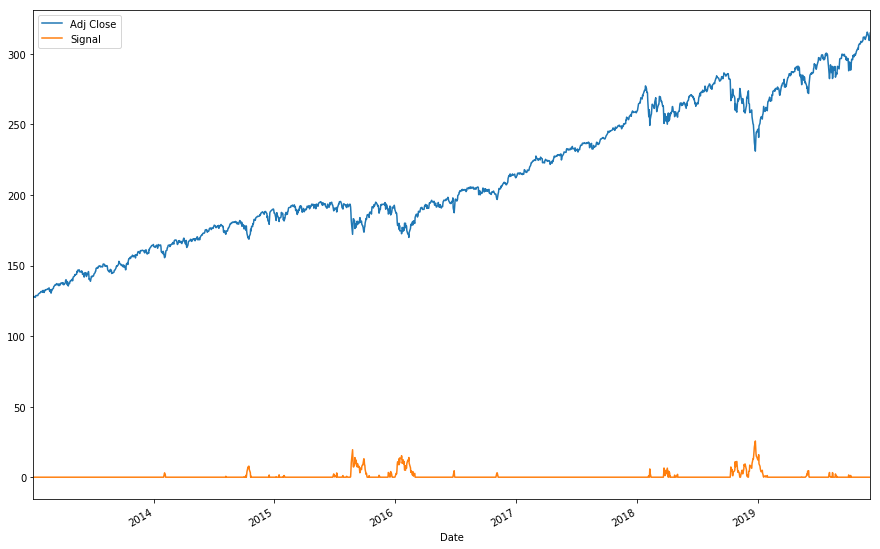

,Open,High,Low,Close,Adj Close,Volume,Normalize Return,SMA20,SMA50,SMA100,SMA200,DIST20,DIST50,DIST100,DIST200,aveDIST,Signal
Date,,,,,,,,,,,,,,,,,
2013-01-02,145.110001,146.149994,144.729996,146.059998,127.877869,192059000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-01-03,145.990005,146.369995,145.339996,145.729996,127.588974,144761800,-0.002259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-01-04,145.970001,146.610001,145.669998,146.369995,128.149261,116817700,0.004391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-01-07,145.850006,146.110001,145.429993,145.970001,127.799103,110002500,-0.002732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-01-08,145.710007,145.910004,144.979996,145.550003,127.431381,121265100,-0.002877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,314.589996,314.660004,311.170013,311.640015,311.640015,75767800,-0.008495,310.561998,302.640598,298.138467,290.876251,0.003471,0.029736,0.045286,0.071383,7.493858,0.0
2019-12-03,308.649994,309.640015,307.130005,309.549988,309.549988,73941700,-0.006707,310.670998,302.867398,298.241287,291.053865,-0.003608,0.022064,0.037918,0.063549,5.996141,0.0
2019-12-04,310.700012,312.119995,310.320007,311.459991,311.459991,49080000,0.006170,310.892497,303.179198,298.362212,291.238268,0.001825,0.027313,0.043899,0.069434,7.123555,0.0


In [16]:
what_stock_do_you_like = 'SPY'
genEDA(start_date, end_date, what_stock_do_you_like, k = 50)
# End program